<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Deep Learning in PyTorch
This notebook provides an introduction to building neural networks in PyTorch for modeling tasks using structured data.

### Contents
1) [Regression Models](#regression)  
2) [Binary Classification Models](#binary-classification)  
3) [Multiclass Classification](#multiclass-classification)  
4) [Saving Models](#saving-models)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download data
import urllib.request
from pathlib import Path
import os
path = Path()
files = {'communities.csv':'https://storage.googleapis.com/aipi_datasets/communities.csv'}
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

# Regression
For regression we use `nn.MSELoss()` as our loss function.

In [3]:
# Read data in and clean up
crimes = pd.read_csv('communities.csv',na_values=['?'])
crimes.drop(columns=['state','country','community','communityname','fold'],inplace=True)
crimes.fillna(crimes.mean(),inplace=True)

X = crimes.iloc[:,:-1]
y = crimes.iloc[:,-1]

print('Shape of X:')
print(X.shape)

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=0.2)

Shape of X:
(1994, 122)


### Step 1: Set up dataloaders for our data
The first step is to set up the dataloaders to feed our data into the model.  We first create a `TensorDataset` for our training data and our test data.  Then we create `DataLoaders` for the training and test data which allow us to iteratively feed the data into our model in batches (called "mini-batches") of a size that we can specify.

### Collate function
A collate function in deep learning transforms and combines individual data samples into batches suitable for model training. Its key purposes are:

- Converting different data formats into tensors
- Handling variable-length sequences through padding
- Ensuring consistent batch shapes
- Custom preprocessing like sorting or normalization

It's especially important when dealing with datasets containing samples of different sizes or structures, like text sequences or images of varying dimensions.

In [4]:
def collate_fn(batch):
    # batch is a list of x and y
    # [(x1, y1), (x2, y2), (x3, y3)]
    # x1  and y1 are tensors
    images, labels = zip(*batch)
    print("Type of images : ", type(images))
    print("Type of first image : ", type(images[0]))
    # images is now a tuple of tensors ((x1), (x2))
    # labels is a tuple of tensors (y1, y2)
    
    print("Type of labels: ", type(labels))
    print("Type of labels[0]: ", type(labels[0]))
    
    images = torch.vstack([torch.tensor(img) for img in images])
    labels = torch.tensor(labels)
    
    return torch.tensor(images), torch.tensor(labels)

batchsize = 32
# Convert training and test data to TensorDatasets
trainset = TensorDataset(torch.from_numpy(np.array(X_train).astype('float32')), 
                        torch.from_numpy(np.array(y_train).astype('float32')).view(-1,1))
testset = TensorDataset(torch.from_numpy(np.array(X_test).astype('float32')), 
                        torch.from_numpy(np.array(y_test).astype('float32')).view(-1,1))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True, collate_fn = collate_fn)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False, collate_fn = collate_fn)
inp, target = next(iter(trainloader))
print(inp.shape)

Type of images :  <class 'tuple'>
Type of first image :  <class 'torch.Tensor'>
Type of labels:  <class 'tuple'>
Type of labels[0]:  <class 'torch.Tensor'>
torch.Size([32, 122])


In [5]:
# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

### Step 2: Define our neural network architecture
Next, we will define a model, feed-forward neural network for this chapter..
For simplicity, we will use 3-layer, 2 hidden layers and 1 hidden-to-output layer, feed-forward net. Each layer is a fully-connected layer where the module `torch.nn.Linear` is the implementation of it. Also, we will apply ReLU activation for each layer.

Basically, we are required to define a member method of `forward(self, x)` when we define a class for any customized network. It represents a forward pass of a computational graph and a backward pass (back-propagation) with automatic differentiation will be performed later based on this forward definition.

In [26]:
class RegressionNet(nn.Module):
    def __init__(self, n_hidden1, n_hidden2):
        super().__init__()
        self.hidden1 = nn.Linear(122, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, 1)

    def forward(self, x, criterion = None, labels = None):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        if self.training and criterion is not None and labels is not None:
            x = criterion(x, labels)
        return x

# Instantiate our neural network
net = RegressionNet(n_hidden1=50, n_hidden2=5)

### Step 3: Define a cost / loss function and optimizer
We will use Mean Squared Error as our loss function, which is usually named `criterion` in PyTorch.  For our optimizer we will use stochastic gradient descent (SGD).

When we create an optimizer in PyTorch, we need to pass in the parameters that we want to optimize (train), which are our weights. We can retrieve all trainable parameters of the model by calling `model.parameters()`.

In [27]:
# Define the cost / loss function
criterion = nn.MSELoss()
# Define the method of updating the weights each iteration
optimizer = optim.SGD(net.parameters(), lr=0.01)

### Step 4: Train the model
To train our model, we perform the following four steps in a loop, using one input mini-batch at a time:  
    1) Make a forward pass through the network to calculate the network output  
    2) Use the network output to calculate the cost/loss  
    3) Calculate the gradient of the cost/loss with respect to the weights by performing a backward pass through the network with loss.backward()  
    4) Update the weights by taking a step with the optimizer

In [28]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device):
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode, Very Important
    cost = []
    for epoch in range(num_iter):

        running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            # model.forward(inputs) is equivalent to calling model(inputs)
            loss = model(inputs, criterion, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # Add the loss to running loss for the epoch
            running_loss += loss.item()

        cost.append(running_loss)
    return cost

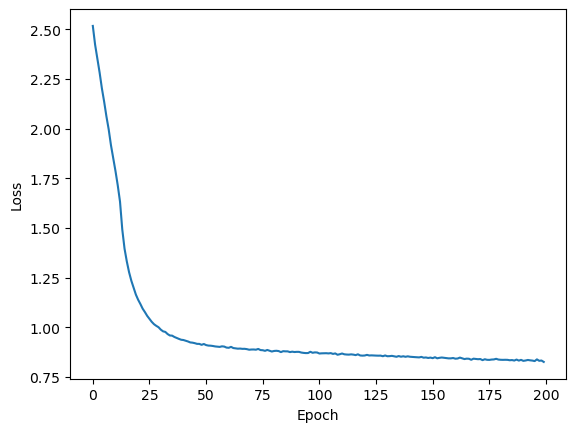

In [29]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Number of iterations (epochs) to train
n_iter = 200

cost_path = train_model(net,criterion,optimizer,trainloader,n_iter,device)

plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Step 5: Test the model on the test set

In [30]:
%%time
with torch.set_grad_enabled(True):
    net = net.to(device)
    net.eval()
    test_preds = []
    # Calculate the predictions on the test set and add to list
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        test_preds.extend(outputs.cpu().squeeze().tolist())
test_mse = 1/len(y_test)*np.sum((np.array(test_preds)-np.array(y_test))**2)
print('The test set MSE of your model is {:.4f}'.format(test_mse))

The test set MSE of your model is 0.0209
CPU times: user 20.5 ms, sys: 1.87 ms, total: 22.4 ms
Wall time: 4.39 ms


In [31]:
%%time
with torch.no_grad(): 
    # Set the model to evaluation mode
    net = net.to(device)
    net.eval()
    test_preds = []
    # Calculate the predictions on the test set and add to list
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        test_preds.extend(outputs.cpu().squeeze().tolist())

test_mse = 1/len(y_test)*np.sum((np.array(test_preds)-np.array(y_test))**2)
print('The test set MSE of your model is {:.4f}'.format(test_mse))

The test set MSE of your model is 0.0209
CPU times: user 17.5 ms, sys: 2.92 ms, total: 20.5 ms
Wall time: 4.07 ms


### Time increase with no_grad

- There is a slight decrease in computation time with torch.no_grad()

## Saving models
To save PyTorch models for later use, we have two options:  
1) We can save the `state_dict` which contains all the learned parameters of the model (the weights and biases) but not the architecture itself.  To use it, we instantiate a new model of the desired architecture and then load the saved `state_dict` to assign values to all the parameters in the model  
2) We can alternatively save the entire model including the architecture, and then load it up and use it for prediction

In [30]:
# OPTION 1: Save the state dictionary of the model

model_dir = 'models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'model_state_dict.pt'

# Save the model's learned parameters (state_dict)
torch.save(net.state_dict(), model_dir+filename)

In [31]:
# Initialize new model and load state dict previously saved into it
model = Multiclass_Net(n_input=4, n_hidden1=100, n_hidden2=50, n_hidden3=10, n_output=3)
model.load_state_dict(torch.load(model_dir+filename))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Test loaded model
acc = test_model(model,testloader,device)
print()
print('Test set accuracy is {:.3f}'.format(acc))

Model's state_dict:
hidden1.weight 	 torch.Size([100, 4])
hidden1.bias 	 torch.Size([100])
hidden2.weight 	 torch.Size([50, 100])
hidden2.bias 	 torch.Size([50])
hidden3.weight 	 torch.Size([10, 50])
hidden3.bias 	 torch.Size([10])
out.weight 	 torch.Size([3, 10])
out.bias 	 torch.Size([3])

Test set accuracy is 1.000


In [32]:
# OPTION 2: Save the entire model

model_dir = 'models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'fullmodel.pt'

# Save the entire model
torch.save(net, model_dir+filename)

In [33]:
# Load model
model2 = torch.load(model_dir+filename)

# Test loaded model
acc = test_model(model2,testloader,device)
print('Test set accuracy is {:.3f}'.format(acc))

Test set accuracy is 1.000
